In [2]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
import torchvision.transforms as T

In [4]:
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
SRC_PATH = PROJECT_ROOT / "src"

sys.path.append(str(SRC_PATH))

print(SRC_PATH)

C:\Users\user\Documents\esophageal_cancer_cv\src


In [5]:
from model import build_resnet18
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = build_resnet18()
model.load_state_dict(
    torch.load(
        "C:/Users/user/Documents/esophageal_cancer_cv/model/best_model.pth",
        map_location=device
    )
)

model.to(device)
model.eval()

C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\user\AppData\Local\Temp\ipykernel_23832\3771571204.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURIT

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
PROJECT_ROOT = Path("..").resolve()

DATA_ROOT = PROJECT_ROOT / "data" / "raw"
SPLITS_ROOT = PROJECT_ROOT / "data" / "splits"

test_csv = SPLITS_ROOT / "test.csv"
print(test_csv)

C:\Users\user\Documents\esophageal_cancer_cv\data\splits\test.csv


In [7]:
class EsophagealPatchDataset(Dataset):

    def __init__(self, csv_file, transform=None):

        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        img_path = Path(row["image_path"])
        label = int(row["label"])

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
test_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [9]:
test_dataset = EsophagealPatchDataset(
    csv_file=test_csv,
    transform=test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print("Test samples:", len(test_dataset))

Test samples: 4920


In [10]:
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)

        
        labels = labels.to(device)

        outputs = model(images)           # logits
        probs = torch.sigmoid(outputs)    # probabilities

        probs = probs.squeeze().cpu().numpy()
        labels = labels.cpu().numpy()

        all_probs.extend(probs)
        all_labels.extend(labels)

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

print("Total samples:", len(all_labels))

100%|██████████| 154/154 [01:56<00:00,  1.32it/s]

Total samples: 4920


In [11]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(all_labels, all_probs)
print(f"Test ROC-AUC: {roc_auc:.4f}")

Test ROC-AUC: 0.9869


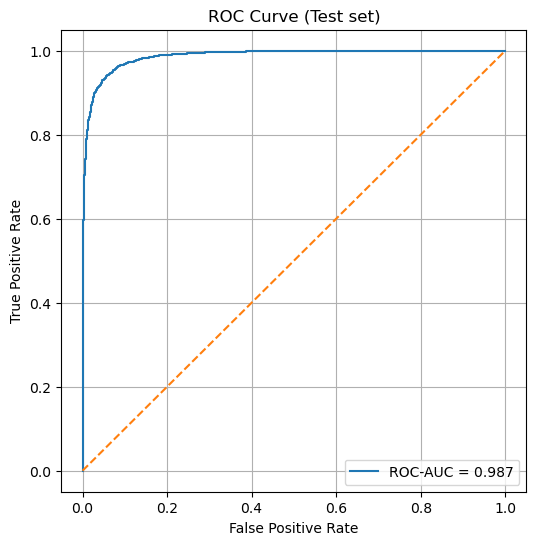

In [12]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test set)")
plt.legend()
plt.grid()
plt.show()

In [13]:
threshold = 0.5
preds = (all_probs >= threshold).astype(int)

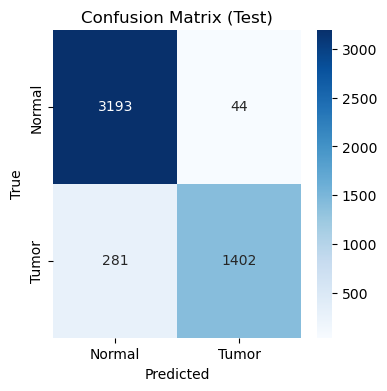

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, preds)

plt.figure(figsize=(4, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "Tumor"],
    yticklabels=["Normal", "Tumor"]
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test)")
plt.show()

In [15]:
from sklearn.metrics import classification_report

print(
    classification_report(
        all_labels,
        preds,
        target_names=["Normal", "Tumor"]
    )
)

              precision    recall  f1-score   support

      Normal       0.92      0.99      0.95      3237
       Tumor       0.97      0.83      0.90      1683

    accuracy                           0.93      4920
   macro avg       0.94      0.91      0.92      4920
weighted avg       0.94      0.93      0.93      4920



In [16]:
target_layer = model.layer4[-1]

In [17]:
import torch.nn.functional as F

In [18]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        self.model.zero_grad()

        output = self.model(x)

        if output.ndim == 2:  # (B, C)
            if class_idx is None:
                class_idx = output[0].argmax()
            score = output[0, class_idx]
        else:  # (B,)
            score = output[0]

        score.backward(retain_graph=True)

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)

        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam


In [19]:
grad_cam = GradCAM(model, target_layer)

images, labels = next(iter(test_loader))
images = images.to(device)
images.requires_grad_(True)

cams = grad_cam(images)
cams = cams.detach().cpu().numpy()

In [22]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def show_cam_on_image(img, cam):
    img = img.detach().permute(1, 2, 0).cpu().numpy()

    img = img * IMAGENET_STD + IMAGENET_MEAN
    img = np.clip(img, 0, 1)

    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = heatmap[..., ::-1] / 255.0  # BGR → RGB

    overlay = 0.4 * heatmap + 0.6 * img
    overlay = np.clip(overlay, 0, 1)

    return overlay

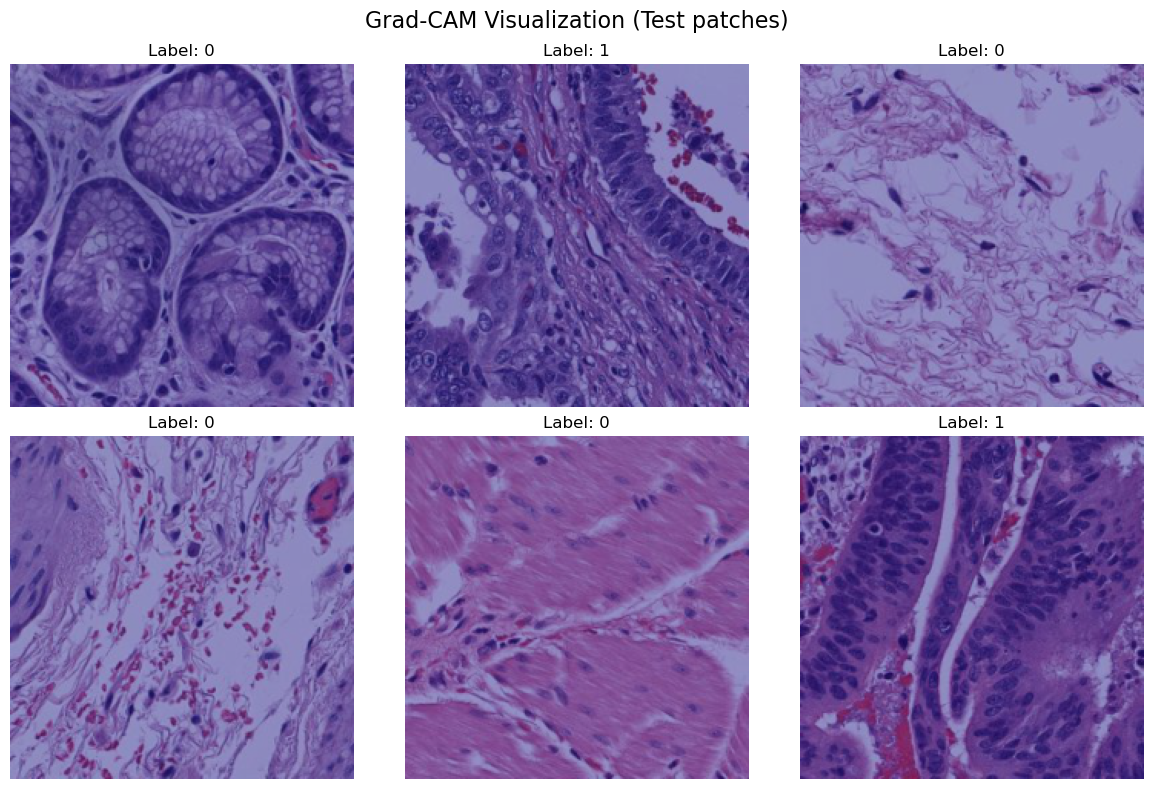

In [26]:
import cv2

num_examples = 6

plt.figure(figsize=(12, 8))

for i in range(num_examples):
    overlay = show_cam_on_image(images[i], cams[i])

    plt.subplot(2, 3, i + 1)
    plt.imshow(overlay)
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")

plt.suptitle("Grad-CAM Visualization (Test patches)", fontsize=16)
plt.tight_layout()
plt.show()

In [27]:
from pathlib import Path

Path("C:/Users/user/Documents/esophageal_cancer_cv/results/gradcam/tumor").mkdir(parents=True, exist_ok=True)
Path("C:/Users/user/Documents/esophageal_cancer_cv/results/gradcam/non_tumor").mkdir(parents=True, exist_ok=True)

In [28]:
num_saved = 0
max_save = 10

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.numpy()

    cams = grad_cam(images).detach().cpu().numpy()

    for i in range(len(images)):
        overlay = show_cam_on_image(images[i], cams[i])

        cls = "tumor" if labels[i] == 1 else "non_tumor"
        save_path = f"C:/Users/user/Documents/esophageal_cancer_cv/results/gradcam/{cls}/{num_saved:03d}.png"

        cv2.imwrite(
            save_path,
            cv2.cvtColor((overlay * 255).astype("uint8"), cv2.COLOR_RGB2BGR)
        )

        num_saved += 1
        if num_saved >= max_save:
            break
    if num_saved >= max_save:
        break
